# Project 7: Use Deep Learning to detect Bad Buzz


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import math
import os
import random

# sklean library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report

import time
import gc
import warnings
gc.collect()
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
from pandas.plotting import parallel_coordinates
import seaborn as sns


# 0. Explanation of the business need.

Business needs: Air Paradis wants a prototype of an AI product that can predict the sentiment associated with a tweet. Specifically, the project is to prepare a functional prototype of a mode that predicts whether a tweet expresses a negative sentiment or not, from information about tweets (user who posted, content, time of posting).

# 1. Preprocess data

It contains the following 6 fields:

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

In [2]:
columns = ["target", "ids", "date", "flag", "user", "text"]

In [3]:
%%time
df_raw = pd.read_csv('data/sentiment_data.csv',encoding='ISO-8859-1',names=columns)

CPU times: total: 3.27 s
Wall time: 6.48 s


In [4]:
print(df_raw.shape)
df_raw.head()

(1600000, 6)


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### 1.1 Target Variable

In [5]:
df_raw['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

Now we need to transform the target variable

In [6]:
label_map = {0: 'Negative', 2: 'Neutral', 4: 'Positive'}

In [7]:
%%time
df_raw.target = df_raw.target.apply(lambda x: label_map[int(x)])

CPU times: total: 156 ms
Wall time: 630 ms


In [8]:
df_raw['target'].value_counts()

target
Negative    800000
Positive    800000
Name: count, dtype: int64

#### 1.2 Pre-process text data

In [9]:
import spacy
import string

# Load the English NLP model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "tagger"])

def clean_token_lemmatize(texts, batch_size=1000):
    cleaned_texts = []
    
    # Use nlp.pipe to process texts in batches for efficiency
    for doc in nlp.pipe(texts, batch_size=batch_size):
        # Extract and clean tokens based on your conditions
        cleaned_tokens = [
            token.lemma_.lower() for token in doc
            if token.is_alpha and not token.is_stop and not token.like_num and token.text not in string.punctuation
        ]
        # Join tokens back into a single cleaned text
        cleaned_texts.append(" ".join(cleaned_tokens))
    
    return cleaned_texts

In [10]:
#split into train and test dataset

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_raw, test_size=0.2,random_state=42)

In [12]:
%%time
df_test['text_processed'] = clean_token_lemmatize(df_test['text'], batch_size=500)

CPU times: total: 7min 13s
Wall time: 11min 53s


In [13]:
%%time
df_train['text_processed'] = clean_token_lemmatize(df_train['text'], batch_size=500)

CPU times: total: 27min 25s
Wall time: 48min 35s


Save the preprocessed data to csv for future use

In [14]:
df_test.to_csv('df_test.csv')
df_train.to_csv('df_train.csv')

In [19]:
df_test['target'].value_counts(normalize=True)

target
Positive    0.501581
Negative    0.498419
Name: proportion, dtype: float64

In [20]:
df_train['target'].value_counts(normalize=True)

target
Negative    0.500395
Positive    0.499605
Name: proportion, dtype: float64

In [15]:
del df_raw
gc.collect()

0

# 2. Modeling

## 2.1 load pre-prossed data and split train test validation

In [3]:
## load in preprocessed data
df_raw = pd.read_csv('df_stem_lemma.csv')

In [4]:
df_raw[df_raw['text_processed_lemma'].isna()].head()

,Unnamed: 0,target,ids,date,flag,user,text,is_negative,text_processed_stem,text_processed_lemma
208,208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy,1,NaN,NaN
249,249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy,1,NaN,NaN
282,282,0,1467881474,Mon Apr 06 22:38:20 PDT 2009,NO_QUERY,__Susan__,@ITS_NEMESIS -------,1,NaN,NaN
308,308,0,1467892515,Mon Apr 06 22:41:16 PDT 2009,NO_QUERY,Tuhtsqueen,@qweendassah no...he's still miss'n...,1,NaN,NaN
356,356,0,1467900431,Mon Apr 06 22:43:29 PDT 2009,NO_QUERY,cescajo,last one!!! but still not done!!!,1,NaN,NaN


In [5]:
data = df_raw[['text_processed_lemma', 'text_processed_stem', 'is_negative']]
data.isna().sum().sort_values(ascending=False)

text_processed_lemma    13148
text_processed_stem     13148
is_negative                 0
dtype: int64

In [6]:
data = data.dropna()

In [7]:
data.isna().sum().sort_values(ascending=False)

text_processed_lemma    0
text_processed_stem     0
is_negative             0
dtype: int64

In [8]:
del df_raw

train - test split

In [9]:
from sklearn.model_selection import train_test_split

# Step 1: Split data into training (70%) and temp (30%) for validation and testing
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, stratify=data['is_negative'])

# Step 2: Split temp data into validation (15%) and test (15%)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['is_negative'])

In [10]:
train_data['is_negative'].value_counts()

is_negative
1    555548
0    555248
Name: count, dtype: int64

In [11]:
val_data['is_negative'].value_counts()

is_negative
1    119046
0    118982
Name: count, dtype: int64

In [12]:
test_data['is_negative'].value_counts()

is_negative
1    119046
0    118982
Name: count, dtype: int64

In [13]:
y_train = train_data['is_negative']
y_val = val_data['is_negative']
y_test = test_data['is_negative']


In [14]:
del data

## 2.2 logistic regression

For logistics regression we will use BOW:

Next we create a bag-of-words (BOW), which is a simple and widely used representation for text data in natural language processing (NLP). It transforms a collection of text documents into numerical feature vectors by considering only the presence or frequency of words, disregarding grammar and word order. 

Frequency Thresholding: This helps in excluding rare words or very frequent words from the BoW model. This is achieved using min_df (minimum document frequency) and max_df (maximum document frequency) in CountVectorizer.
- min_df (set at 0.5%) : to filter out very rare words that appear in only a few reviews which are likely noise or typos
- max_df (set at 90%) : to filter out  be overly common or non-informative words.
  
To avoid information leakage, we will fit only on train dataset.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer with frequency threshold and word normalization
vectorizer = CountVectorizer(lowercase=True, min_df=0.005, max_df=0.90, stop_words='english')  # Apply frequency thresholds 

# Step 1: Fit the vectorizer only on the training data
X_train = vectorizer.fit_transform(train_data['text_processed_lemma'])

# Step 2: Transform both the training and test data using the same vectorizer
X_test = vectorizer.transform(test_data['text_processed_lemma'])


In [15]:
# Get feature names (words) and their frequencies
word_freq = X_train.toarray().sum(axis=0)
words = vectorizer.get_feature_names_out()
# Create a dictionary of words and their frequencies
word_freq_dict = dict(zip(words, word_freq))
print(dict(sorted(word_freq_dict.items(), key=lambda item: item[1], reverse=True)))

{'good': 72689, 'day': 68658, 'like': 62679, 'got': 56053, 'today': 54009, 'work': 51607, 'going': 51481, 'love': 51451, 'nt': 47749, 'lol': 46634, 'time': 45953, 'know': 41412, 'night': 34235, 'want': 33775, 'new': 33683, 'think': 33103, 'amp': 32368, 'thanks': 32133, 'home': 32089, 'oh': 31438, 'miss': 28941, 'need': 28748, 'morning': 27347, 'hope': 26990, 'tomorrow': 26983, 'great': 26648, 'twitter': 25797, 'haha': 24974, 'feel': 24182, 'sad': 23451, 'fun': 22738, 'wish': 22518, 'sleep': 22288, 'right': 22071, 'bad': 21812, 'happy': 21360, 'sorry': 20977, 'tonight': 20538, 'come': 19993, 'way': 19521, 'getting': 19422, 'nice': 18793, 'better': 18502, 'watching': 18166, 'yeah': 17721, 'wait': 17706, 'bed': 17655, 'week': 17162, 'school': 16401, 'people': 16335, 'hate': 15893, 'days': 15286, 'hey': 15038, 'yes': 14782, 'weekend': 14735, 'awesome': 14557, 'thank': 14417, 'soon': 14160, 'long': 13593, 'working': 13553, 'little': 13452, 'wanna': 13267, 'best': 13159, 'tired': 13010, 'ok'

In [18]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

In [19]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_log_reg)
report = classification_report(y_test, y_pred_log_reg)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.6778795861008533
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.78      0.71     79322
           1       0.73      0.57      0.64     79364

    accuracy                           0.68    158686
   macro avg       0.69      0.68      0.67    158686
weighted avg       0.69      0.68      0.67    158686



## 2.3 Deep Neural Network

Recurrent Neural Networks are made of neurons: data-processing nodes that work together to perform complex tasks. The neurons are organized as input, output, and hidden layers. The input layer receives the information to process, and the output layer provides the result. Data processing, analysis, and prediction take place in the hidden layer. 

RNNs work by passing the sequential data that they receive to the hidden layers one step at a time. However, they also have a self-looping or recurrent workflow: the hidden layer can remember and use previous inputs for future predictions in a short-term memory component. It uses the current input and the stored memory to predict the next sequence. 

For example, consider the sequence: Apple is red. You want the RNN to predict red when it receives the input sequence Apple is. When the hidden layer processes the word Apple, it stores a copy in its memory. Next, when it sees the word is, it recalls Apple from its memory and understands the full sequence: Apple is for context. It can then predict red for improved accuracy. This makes RNNs useful in speech recognition, machine translation, and other language modeling tasks.
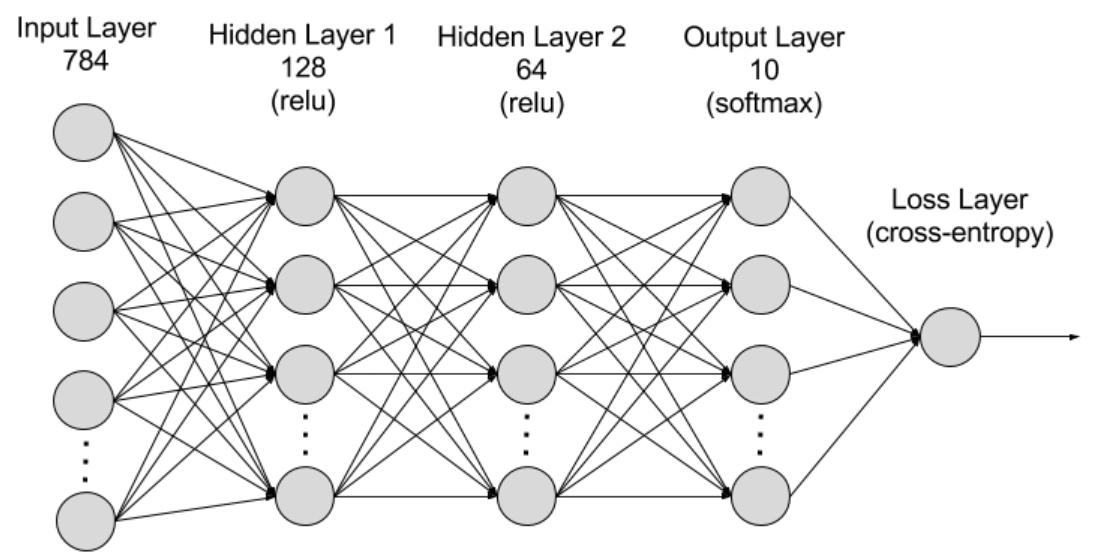

There are three types of common recurrent neural networks: Simple RNNs, GRUs, and LSTMs. They have differences in structure and functionality that make them suited for handling various types of sequence data. 
- **Simple RNN**:
  - This is the simplest form of a recurrent neural network. It processes input one step at a time, feeding the output of the current step back into the network to be used in the next time step.
  - Simple RNNs are best for short and simple sequences, and struggle with learning long sequences because of the vanishing gradient problem. As RNN processes more steps it suffers from vanishing gradient more than other neural network architectures.
- **GRU (Gated Recurrent Units)**
  - A more sophisticated RNN with gates to control information flow. GRUs use two gates—update and reset gates—that decide which information to pass through and retain. Update gate controls how much of the past information should be kept and passed to the future. Reset gate determines how much of the previous state to forget.
  - GRUs are simpler than LSTMs and require less memory, making them computationally efficient. They are effective at capturing dependencies over longer sequences than simple RNNs. GRUs are useful for moderate sequence lengths or when computational efficiency is a priority.
- **LSTM (Long Short-Term Memory)**
  - A more complex RNN with three gates—input, forget, and output gates—that help maintain long-term dependencies. Forget gate determines what information to discard from the cell state. Input gate decides what new information to store in the cell state. Output gate controls the output of the cell state for the current step.
  - LSTMs are very effective at learning and maintaining long-term dependencies, addressing the vanishing gradient problem more effectively than GRUs or simple RNNs. It is ideal for long sequences or tasks requiring retention of information over extended time steps, like speech recognition, machine translation, and time-series forecasting.

In this exercise, we will choose simple RNN due to computation restriction.

### 2.3.1 Word2Vec embedding (Lemma)

Word2Vec generates embeddings using two main approaches: Continuous Bag of Words (CBOW) and Skip-gram. CBOW predicts a target word based on its context, while Skip-gram predicts surrounding words given a target word.
- Advantages:
    - Contextual Similarity: Good at capturing semantic similarity between words based on their context.
    - Efficiency: Lightweight and fast to train, especially with Skip-gram for larger datasets.
- Limitations:
    - OOV (Out-of-Vocabulary) Problem: Words not in the training vocabulary won’t have embeddings.
    - Word-level Embeddings Only: Each word has a single vector representation, so it does not capture subword information.
- Use Cases: Works well for general-purpose NLP tasks, where vocabulary is relatively consistent, but may miss out on nuances in tweets with slang or misspellings.

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec

Initialize and Configure Tokenizer with an OOV Token and Fixed Vocabulary Size
Adding an OOV token and restricting the vocabulary size will allow the model to handle new or rare words efficiently.


In [16]:
# Define tokenizer with an OOV token and a max vocabulary size (e.g., top 1000 words)
max_vocab_size = 5000  # Adjust as needed based on your data
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['text_processed_lemma'])

In [17]:
len(tokenizer.word_index)

206345

Prepare a Word2Vec embedding model, and Modify the Embedding Matrix to Include OOV Token Embeddings
Include an embedding for the OOV token to handle unseen words during inference. For OOV words, we could initialize embeddings randomly or use a default embedding vector

In [18]:
from gensim.models import Word2Vec
# Get actual vocabulary size after tokenizing
vocab_size = min(max_vocab_size, len(tokenizer.word_index) + 1)

# Initialize the embedding matrix with random values for OOV handling
# Train Word2Vec model
embedding_dim = 100  # You can adjust the dimension
word2vec_model = Word2Vec(sentences=train_data['text_processed_lemma'], vector_size=embedding_dim, window=5, min_count=1, workers=4)

embedding_matrix = np.random.normal(size=(vocab_size, embedding_dim))  # Random initialization for OOV words

# Populate the embedding matrix with Word2Vec vectors
for word, i in tokenizer.word_index.items():
    if i < vocab_size:  # Restrict to max_vocab_size
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(embedding_dim,))  # Random vector for OOV words

Tokenize and Pad the Sequences: Convert the text data to padded sequences with the restricted vocabulary and OOV token.

In [19]:
train_token = tokenizer.texts_to_sequences(train_data['text_processed_stem'])
train_token[:10]

[[1272, 476, 1, 486, 2769, 1, 2, 19, 25, 1243, 1],
 [440, 22, 88, 1, 50, 24, 1, 1, 631, 1, 928, 9, 1, 1],
 [561, 1, 3246, 873, 1, 1, 2422],
 [572, 86, 916, 982, 33],
 [497, 158, 43, 1460],
 [1, 141, 969, 61],
 [34, 10, 59, 180, 1, 1, 42],
 [1, 1, 3780, 2702],
 [385, 1],
 [235, 235, 14, 4148, 527, 3587, 104]]

In [20]:
# Calculate sentence lengths (number of tokens in each sentence)
train_lengths = [len(sentence) for sentence in train_token]

# Display some statistics
print("Mean length:", np.mean(train_lengths))
print("Median length:", np.median(train_lengths))
print("90th percentile length:", np.percentile(train_lengths, 90))
print("95th percentile length:", np.percentile(train_lengths, 95))

Mean length: 6.092454420073532
Median length: 6.0
90th percentile length: 11.0
95th percentile length: 12.0


In [21]:
max_len = 15  # Adjust as needed, based on max tweet length
# Convert texts to sequences and pad
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['text_processed_lemma']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['text_processed_lemma']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['text_processed_lemma']), maxlen=max_len)


In [22]:
# Define RNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=max_len,
                    trainable=True))  # Set to True if want to fine-tune
model.add(SimpleRNN(units=64, return_sequences=False))  # Can also use LSTM or GRU here
model.add(Dense(1, activation='sigmoid'))  # Adjust the output layer for multi-class if necessary

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 289s 8ms/step - accuracy: 0.7292 - loss: 0.5319 - val_accuracy: 0.7664 - val_loss: 0.4823
Epoch 2/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 340s 9ms/step - accuracy: 0.7701 - loss: 0.4770 - val_accuracy: 0.7694 - val_loss: 0.4770
Epoch 3/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 294s 8ms/step - accuracy: 0.7760 - loss: 0.4676 - val_accuracy: 0.7701 - val_loss: 0.4756
Epoch 4/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 278s 8ms/step - accuracy: 0.7796 - loss: 0.4623 - val_accuracy: 0.7716 - val_loss: 0.4745
Epoch 5/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 290s 8ms/step - accuracy: 0.7821 - loss: 0.4581 - val_accuracy: 0.7709 - val_loss: 0.4755


In [23]:
#Make predictions
y_pred_rnn_w2v = model.predict(X_test)

# Convert the continuous values (probabilities) to binary class labels using a threshold
y_pred_rnn_w2v_binary = (y_pred_rnn_w2v >= 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rnn_w2v_binary)
report = classification_report(y_test, y_pred_rnn_w2v_binary)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

7439/7439 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step
Accuracy: 0.7708294822457862
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77    118982
           1       0.78      0.76      0.77    119046

    accuracy                           0.77    238028
   macro avg       0.77      0.77      0.77    238028
weighted avg       0.77      0.77      0.77    238028



save the tokenizer and trained model

In [26]:
import pickle

In [27]:
filename = 'tokenizer.pkl'
pickle.dump(tokenizer, open(filename, 'wb'))

In [25]:
filename = 'w2v_lemma_rnn_model.pkl'
pickle.dump(model, open(filename, 'wb'))

### 2.3.2 Word2Vec embedding (Stem)

We will use Word2Vec embedding with stem preprocessing this time to check if there is any performance difference.

In [25]:
# Define tokenizer with an OOV token and a max vocabulary size (e.g., top 1000 words)
max_vocab_size = 5000  # Adjust as needed based on your data
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['text_processed_stem'])

In [26]:
from gensim.models import Word2Vec
# Get actual vocabulary size after tokenizing
vocab_size = min(max_vocab_size, len(tokenizer.word_index) + 1)

# Initialize the embedding matrix with random values for OOV handling
# Train Word2Vec model
embedding_dim = 100  # You can adjust the dimension
word2vec_model = Word2Vec(sentences=train_data['text_processed_stem'], vector_size=embedding_dim, window=5, min_count=1, workers=4)

embedding_matrix = np.random.normal(size=(vocab_size, embedding_dim))  # Random initialization for OOV words

# Populate the embedding matrix with Word2Vec vectors
for word, i in tokenizer.word_index.items():
    if i < vocab_size:  # Restrict to max_vocab_size
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(embedding_dim,))  # Random vector for OOV words

In [27]:
train_token = tokenizer.texts_to_sequences(train_data['text_processed_stem'])
# Calculate sentence lengths (number of tokens in each sentence)
train_lengths = [len(sentence) for sentence in train_token]

# Display some statistics
print("Mean length:", np.mean(train_lengths))
print("Median length:", np.median(train_lengths))
print("90th percentile length:", np.percentile(train_lengths, 90))
print("95th percentile length:", np.percentile(train_lengths, 95))

Mean length: 6.092454420073532
Median length: 6.0
90th percentile length: 11.0
95th percentile length: 12.0


In [28]:
max_len = 15  # Adjust as needed, based on max tweet length
# Convert texts to sequences and pad
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['text_processed_stem']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['text_processed_stem']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['text_processed_stem']), maxlen=max_len)

In [29]:
# Define RNN model
model_stem = Sequential()
model_stem.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=max_len,
                    trainable=True))  # Set to True if you want to fine-tune
model_stem.add(SimpleRNN(units=64, return_sequences=False))  # Can also use LSTM or GRU here
model_stem.add(Dense(1, activation='sigmoid'))  # Adjust the output layer for multi-class if necessary

# Compile model
model_stem.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model_stem.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 348s 10ms/step - accuracy: 0.7283 - loss: 0.5344 - val_accuracy: 0.7679 - val_loss: 0.4834
Epoch 2/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 342s 10ms/step - accuracy: 0.7694 - loss: 0.4800 - val_accuracy: 0.7692 - val_loss: 0.4805
Epoch 3/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 352s 10ms/step - accuracy: 0.7734 - loss: 0.4731 - val_accuracy: 0.7710 - val_loss: 0.4782
Epoch 4/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 329s 9ms/step - accuracy: 0.7770 - loss: 0.4683 - val_accuracy: 0.7705 - val_loss: 0.4789
Epoch 5/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 355s 9ms/step - accuracy: 0.7791 - loss: 0.4640 - val_accuracy: 0.7689 - val_loss: 0.4808


In [30]:
#Make predictions
y_pred_rnn_w2v = model_stem.predict(X_test)

# Convert the continuous values (probabilities) to binary class labels using a threshold
y_pred_rnn_w2v_binary = (y_pred_rnn_w2v >= 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rnn_w2v_binary)
report = classification_report(y_test, y_pred_rnn_w2v_binary)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

7439/7439 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
Accuracy: 0.7673845093854504
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76    118982
           1       0.76      0.78      0.77    119046

    accuracy                           0.77    238028
   macro avg       0.77      0.77      0.77    238028
weighted avg       0.77      0.77      0.77    238028



### 2.3.3 FastText(lemma)

FastText is an advanced word embedding technique developed by Facebook AI Research (FAIR) that extends the Word2Vec model. Unlike Word2Vec, FastText not only considers whole words but also incorporates subword information — parts of words like n-grams. Word2Vec works on the word level, while fastText works on the character n-grams. Word2Vec cannot provide embeddings for out-of-vocabulary words, while fastText can provide embeddings for OOV words. FastText can provide better embeddings for morphologically rich languages compared to word2vec.

1. Train FastText Embeddings on the Training Data
   
Instead of Word2Vec, we’ll use FastText to train embeddings on your dataset. FastText will create embeddings at the subword level, making it robust for handling OOV words.

In [31]:
from gensim.models import FastText
# Train FastText model
embedding_dim = 100  # You can adjust the embedding dimension
fasttext_model = FastText(sentences=train_data['text_processed_lemma'], vector_size=embedding_dim, window=5, min_count=1, workers=4)

2.  Prepare the Embedding Matrix with FastText
   
Since FastText can handle OOV words, we don’t need a separate vector initialization for OOV words. Instead, FastText will generate embeddings for any word based on subword information. The remaining steps are similar to the Word2Vec workflow, but we’ll use fasttext_model.wv for embedding lookup.

In [32]:
# Define tokenizer with OOV token and max vocabulary size
max_vocab_size = 5000  # Adjust based on dataset size
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['text_processed_lemma'])

# Get actual vocabulary size after tokenizing
vocab_size = min(max_vocab_size, len(tokenizer.word_index) + 1)

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_matrix[i] = fasttext_model.wv[word] if word in fasttext_model.wv else np.random.normal(size=(embedding_dim,))

In [33]:
len(tokenizer.word_index)

206345

3. Tokenize and Pad the Sequences
Convert the text data to padded sequences with the restricted vocabulary and OOV token.

In [34]:
train_token = tokenizer.texts_to_sequences(train_data['text_processed_stem'])

In [35]:
train_token[:10]

[[1272, 476, 1, 486, 2769, 1, 2, 19, 25, 1243, 1],
 [440, 22, 88, 1, 50, 24, 1, 1, 631, 1, 928, 9, 1, 1],
 [561, 1, 3246, 873, 1, 1, 2422],
 [572, 86, 916, 982, 33],
 [497, 158, 43, 1460],
 [1, 141, 969, 61],
 [34, 10, 59, 180, 1, 1, 42],
 [1, 1, 3780, 2702],
 [385, 1],
 [235, 235, 14, 4148, 527, 3587, 104]]

In [36]:
# Calculate sentence lengths (number of tokens in each sentence)
train_lengths = [len(sentence) for sentence in train_token]

# Display some statistics
print("Mean length:", np.mean(train_lengths))
print("Median length:", np.median(train_lengths))
print("90th percentile length:", np.percentile(train_lengths, 90))
print("95th percentile length:", np.percentile(train_lengths, 95))

Mean length: 6.092454420073532
Median length: 6.0
90th percentile length: 11.0
95th percentile length: 12.0


In [37]:
max_len = 15  # Adjust as needed, based on max tweet length
# Convert texts to sequences and pad
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['text_processed_lemma']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['text_processed_lemma']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['text_processed_lemma']), maxlen=max_len)

4. Define, Compile and Train the RNN Model

In [38]:
# Define RNN model
model_ft = Sequential()
model_ft.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=max_len,
                    trainable=True))  # Set to True if you want to fine-tune
model_ft.add(SimpleRNN(units=64, return_sequences=False))  # Can also use LSTM or GRU here
model_ft.add(Dense(1, activation='sigmoid'))  # Adjust the output layer for multi-class if necessary

# Compile model
model_ft.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_ft = model_ft.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 356s 10ms/step - accuracy: 0.7462 - loss: 0.5111 - val_accuracy: 0.7688 - val_loss: 0.4804
Epoch 2/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 361s 10ms/step - accuracy: 0.7711 - loss: 0.4768 - val_accuracy: 0.7679 - val_loss: 0.4805
Epoch 3/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 324s 9ms/step - accuracy: 0.7760 - loss: 0.4686 - val_accuracy: 0.7702 - val_loss: 0.4772
Epoch 4/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 309s 9ms/step - accuracy: 0.7797 - loss: 0.4626 - val_accuracy: 0.7681 - val_loss: 0.4779
Epoch 5/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 305s 9ms/step - accuracy: 0.7820 - loss: 0.4590 - val_accuracy: 0.7696 - val_loss: 0.4781


5. Test the model

In [39]:
#Make predictions
y_pred_rnn_ft = model_ft.predict(X_test)

# Convert the continuous values (probabilities) to binary class labels using a threshold
y_pred_rnn_ft_binary = (y_pred_rnn_ft >= 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rnn_ft_binary)
report = classification_report(y_test, y_pred_rnn_ft_binary)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

7439/7439 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step
Accuracy: 0.7697035642865545
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77    118982
           1       0.78      0.75      0.76    119046

    accuracy                           0.77    238028
   macro avg       0.77      0.77      0.77    238028
weighted avg       0.77      0.77      0.77    238028



FastText works best on longer, more complex texts where subword information can make a significant difference (like longer words or compound words). For short texts like tweets, the advantage of FastText's subword-level representations may not be fully utilized, and the model might perform similarly to Word2Vec, or even worse if the subword information introduces noise.

### 2.3.4 FastText(stem)

In [16]:
from gensim.models import FastText
# Train FastText model
embedding_dim = 100  # You can adjust the embedding dimension
fasttext_model = FastText(sentences=train_data['text_processed_stem'], vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [17]:
# Define tokenizer with OOV token and max vocabulary size
max_vocab_size = 5000  # Adjust based on dataset size
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['text_processed_stem'])

# Get actual vocabulary size after tokenizing
vocab_size = min(max_vocab_size, len(tokenizer.word_index) + 1)

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_matrix[i] = fasttext_model.wv[word] if word in fasttext_model.wv else np.random.normal(size=(embedding_dim,))

In [18]:
# Calculate sentence lengths (number of tokens in each sentence)
train_lengths = [len(sentence) for sentence in tokenizer.texts_to_sequences(train_data['text_processed_stem'])]

# Display some statistics
print("Mean length:", np.mean(train_lengths))
print("Median length:", np.median(train_lengths))
print("90th percentile length:", np.percentile(train_lengths, 90))
print("95th percentile length:", np.percentile(train_lengths, 95))

Mean length: 6.092454420073532
Median length: 6.0
90th percentile length: 11.0
95th percentile length: 12.0


In [19]:
max_len = 15  # Adjust as needed, based on max tweet length
# Convert texts to sequences and pad
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['text_processed_stem']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['text_processed_stem']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['text_processed_stem']), maxlen=max_len)

In [20]:
# Define RNN model
model_ft = Sequential()
model_ft.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                    weights=[embedding_matrix], input_length=max_len,
                    trainable=True))  # Set to True if you want to fine-tune
model_ft.add(SimpleRNN(units=64, return_sequences=False))  # Can also use LSTM or GRU here
model_ft.add(Dense(1, activation='sigmoid'))  # Adjust the output layer for multi-class if necessary

# Compile model
model_ft.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_ft = model_ft.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 316s 9ms/step - accuracy: 0.7484 - loss: 0.5101 - val_accuracy: 0.7644 - val_loss: 0.4875
Epoch 2/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 318s 9ms/step - accuracy: 0.7692 - loss: 0.4815 - val_accuracy: 0.7651 - val_loss: 0.4846
Epoch 3/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 298s 9ms/step - accuracy: 0.7749 - loss: 0.4714 - val_accuracy: 0.7695 - val_loss: 0.4801
Epoch 4/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 297s 9ms/step - accuracy: 0.7786 - loss: 0.4653 - val_accuracy: 0.7685 - val_loss: 0.4817
Epoch 5/5
34713/34713 ━━━━━━━━━━━━━━━━━━━━ 282s 8ms/step - accuracy: 0.7813 - loss: 0.4609 - val_accuracy: 0.7697 - val_loss: 0.4804


In [21]:
#Make predictions
y_pred_rnn_ft = model_ft.predict(X_test)

# Convert the continuous values (probabilities) to binary class labels using a threshold
y_pred_rnn_ft_binary = (y_pred_rnn_ft >= 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rnn_ft_binary)
report = classification_report(y_test, y_pred_rnn_ft_binary)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

7439/7439 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
Accuracy: 0.7686070546322281
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.78      0.77    118982
           1       0.77      0.76      0.77    119046

    accuracy                           0.77    238028
   macro avg       0.77      0.77      0.77    238028
weighted avg       0.77      0.77      0.77    238028



## 2.4 BERT Model

**Attention Mechanism** is a concept in machine learning, particularly in deep learning models, that allows a model to dynamically focus on different parts of the input when making predictions. The idea mimics human attention: rather than processing all information equally, the model selectively emphasizes certain parts of the input data based on their relevance to the task at hand.
  - Focuses on relationships between different sequences (e.g., input and output in translation).
  - Common in tasks like encoder-decoder models (e.g., machine translation).
  - Helps the model align two sequences.

**Self-attention** is a specific type of attention mechanism where the model computes the relationships (or dependencies) within the same input sequence. It enables the model to capture the interactions between all positions of the input.
  - Focuses on relationships within the same sequence (e.g., a sentence).
  - Central to Transformer models, understanding context within a sequence.
  - Helps the model build a contextual representation of a single sequence.

**BERT** (Bidirectional Encoder Representations from Transformers) is a deep learning model introduced by Google in 2018. It is designed for natural language understanding (NLU) tasks and is based on the Transformer architecture proposed by Vaswani et al. in 2017. The key innovation of BERT lies in its bidirectional contextual understanding, allowing it to learn from both left and right contexts in a sequence.
- Unlike traditional models (e.g., RNNs or unidirectional LSTMs) that process text in one direction, BERT considers both left and right contexts simultaneously during training.
- BERT is pre-trained on large text corpora using two unsupervised objectives:
  - **Masked Language Modeling (MLM)**: Predict masked words in a sentence.
    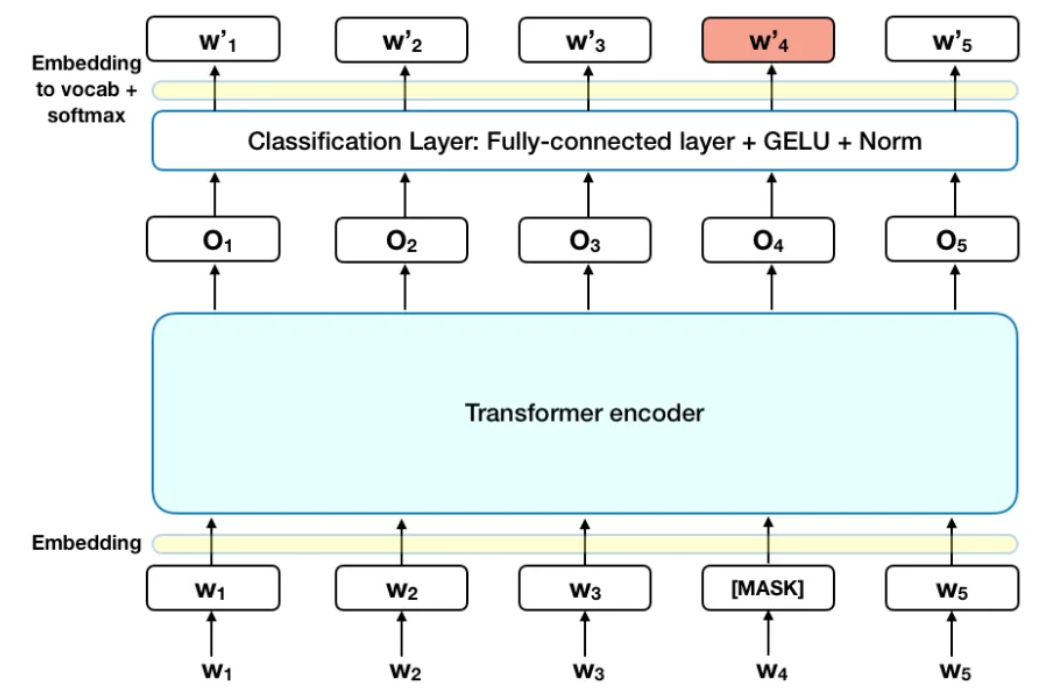
  - **Next Sentence Prediction (NSP)**: Predict whether two sentences are consecutive in the original text.
    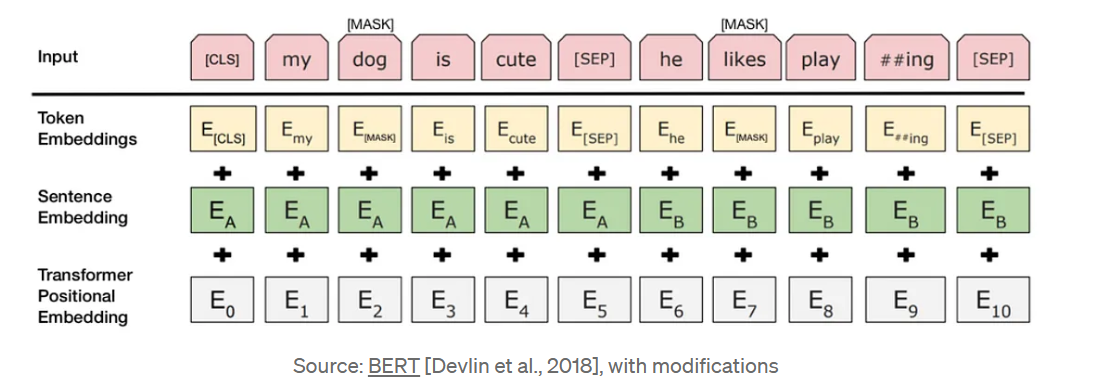
  - It can be fine-tuned for specific downstream tasks like text classification, question answering, or sentiment analysis.

**BERT Architecture**

- The architecture of BERT is a multilayer bidirectional transformer encoder which is quite similar to the transformer model. A transformer architecture is an encoder-decoder network that uses self-attention on the encoder side and attention on the decoder side.
- This model takes the CLS token as input first, then it is followed by a sequence of words as input. Here CLS is a classification token. It then passes the input to the above layers. Each layer applies self-attention and passes the result through a feedforward network after then it hands off to the next encoder. The model outputs a vector of hidden size (768 for BERT BASE). If we want to output a classifier from this model we can take the output corresponding to the CLS token.
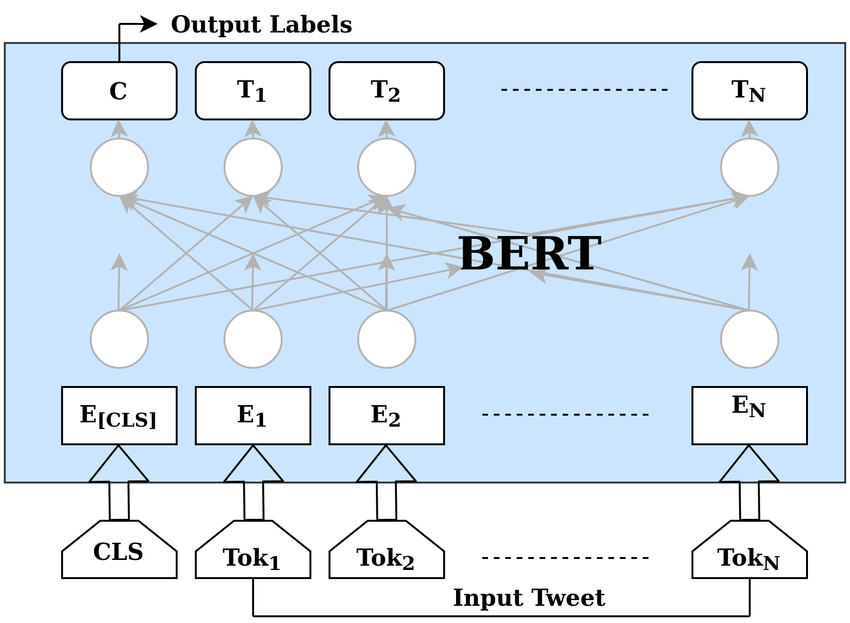

In [2]:
# from transformers import *
# from transformers import BertTokenizer, TFBertModel, BertConfig
# bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)